In [13]:
import sys

if sys.platform=="darwin": #MAC OSX
    !curl https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/train_nominal_000.h5.gz --output train_nominal_000.h5.gz
    !curl https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/test_nominal_000.h5.gz --output test_nominal_000.h5.gz
elif sys.platform == "linux" or sys.platform == "linux2":
    !wget https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/train_nominal_000.h5.gz
    !wget https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/test_nominal_000.h5.gz
!gunzip train_nominal_000.h5.gz
!gunzip test_nominal_000.h5.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 92.6M    0 92.6M    0     0  29.0M      0 --:--:--  0:00:03 --:--:-- 29.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 92.1M    0 92.1M    0     0  28.7M      0 --:--:--  0:00:03 --:--:-- 28.7M


In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset
from torchinfo import summary

import matplotlib.pyplot as plt
import h5py
import numpy as np
import sys,os,time

Matplotlib is building the font cache; this may take a moment.


In [2]:
class ATLASH5HighLevelDataset(torch.utils.data.Dataset):
    def transform(self,data,transform=True):
        if transform:
          #Calculate some metrics from subsample of total
          vals=[]
          Njets=np.max([1000,data.len()])
          for jet in range(Njets): vals.append(data[jet])
          maxval=np.max(vals)
          minval=np.min(vals)
          return (data-minval)/(maxval-minval)
        else:
          return data

    def __init__(self, file_path, transform=True, return_pt=False):
        super(ATLASH5HighLevelDataset, self).__init__()
        h5_file = h5py.File(file_path , 'r')
        self.data=torch.tensor([])
    
        self.C2=self.transform(h5_file['fjet_C2'],transform=transform)
        self.D2=self.transform(h5_file['fjet_D2'],transform=transform)
        self.ECF1=self.transform(h5_file['fjet_ECF1'],transform=transform)
        self.ECF2=self.transform(h5_file['fjet_ECF2'],transform=transform)
        self.ECF3=self.transform(h5_file['fjet_ECF3'],transform=transform)
        self.L2=self.transform(h5_file['fjet_L2'],transform=transform)
        self.L3=self.transform(h5_file['fjet_L3'],transform=transform)
        self.Qw=self.transform(h5_file['fjet_Qw'],transform=transform)
        self.Split12=self.transform(h5_file['fjet_Split12'],transform=transform)
        self.Split23=self.transform(h5_file['fjet_Split23'],transform=transform)
        self.Tau1_wta=self.transform(h5_file['fjet_Tau1_wta'],transform=transform)
        self.Tau2_wta=self.transform(h5_file['fjet_Tau2_wta'],transform=transform)
        self.Tau3_wta=self.transform(h5_file['fjet_Tau3_wta'],transform=transform)
        self.Tau4_wta=self.transform(h5_file['fjet_Tau4_wta'],transform=transform)
        self.ThrustMaj=self.transform(h5_file['fjet_ThrustMaj'],transform=transform)
        self.m=self.transform(h5_file['fjet_m'],transform=transform)
    
        self.pt = h5_file['fjet_pt']
        self.labels = h5_file['labels']
        if "training_weights" in h5_file:
              self.hasWeights=True
              self.weights = h5_file['training_weights']
        else:
              self.hasWeights=False
    
        self.return_pt = return_pt
    
    def __getitem__(self, index):
        self.data=torch.tensor([self.D2[index],self.C2[index],self.ECF1[index],self.ECF2[index],self.ECF3[index],self.L2[index],self.L3[index],self.Qw[index],self.Split12[index],self.Split23[index],self.Tau1_wta[index],self.Tau2_wta[index],self.Tau3_wta[index],self.Tau4_wta[index],self.ThrustMaj[index],self.m[index]])
    
        if self.return_pt:
          self.data=self.data,torch.tensor([self.pt[index]])
    
        if self.hasWeights:
          return self.data,torch.tensor(self.labels[index],dtype=torch.int64),torch.tensor(self.weights[index])
        else:
          return self.data,torch.tensor(self.labels[index],dtype=torch.int64),torch.tensor(1)
    
    def __len__(self):
        return len(self.labels)

In [3]:
def get_ATLAS_inputs(directory,network,batch_size=2**8,return_pt=False):
    
    #Get list of input files
    training_list=[]
    testing_list=[]
    for file in sorted(os.listdir(directory)):
        if not ".h5" in file: continue
        if "train" in file:
            print("Using file %s for training"%(directory+"/"+file))
            training_list.append(directory+"/"+file)
        elif "test" in file:
            print("Using file %s for testing"%(directory+"/"+file))
            testing_list.append(directory+"/"+file)
    
      #concat them
    training_DSlist=[]
    testing_DSlist=[]
    if network!="HL":
        for file in training_list: training_DSlist.append(ATLASH5LowLevelDataset(file,useTransformer=(network=="Transformer"),return_pt=return_pt))
        for file in testing_list: testing_DSlist.append(ATLASH5LowLevelDataset(file,useTransformer=(network=="Transformer"),return_pt=return_pt))
    else:
        for file in training_list: training_DSlist.append(ATLASH5HighLevelDataset(file,transform=True,return_pt=return_pt))
        for file in testing_list: testing_DSlist.append(ATLASH5HighLevelDataset(file,transform=True,return_pt=return_pt))
    training_data = ConcatDataset(training_DSlist)
    testing_data = ConcatDataset(testing_DSlist)
    
    #load them into torch dataloaders 
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)
    test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=True)
    
    #return
    return train_dataloader, test_dataloader

In [4]:
class DNNetwork(nn.Module):
    def __init__(self,Ninputs,useConstituents=False):
        super().__init__()
        self.useConstituents=useConstituents
    
        if self.useConstituents: self.flatten = nn.Flatten()
        #self.norm=nn.BatchNorm1d(Ninputs)
        self.fc1= nn.Linear(Ninputs, 512)
        self.act1=nn.ReLU()
        self.fc2= nn.Linear(512, 512)
        self.act2=nn.ReLU()
        self.fc3= nn.Linear(512, 512)
        self.act3=nn.ReLU()
        self.fc4= nn.Linear(512, 2)
    
    def forward(self, x):
        if self.useConstituents: x = self.flatten(x)
        #x=self.norm(x)
        f1=self.act1(self.fc1(x))
        f2=self.act2(self.fc2(f1))
        f3=self.act3(self.fc3(f2))
        logits = self.fc4(f3)
        return logits


In [17]:
def train(dataloader, model, loss_fn, optimizer, loss_train):
    #set to train mode
    model.train()
    
    #Loop over batches
    size = len(dataloader.dataset)
    for batch, (X, y, w) in enumerate(dataloader):
        dev=device
        X, y, w = X.to(dev), y.to(dev), w.to(dev)
      
        # Compute loss
        pred = model(X)
        loss = loss_fn(pred, y)
        loss = (loss * w / w.sum()).sum()
      
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #Print some status
        if batch % 100 == 0:
            lossval, current = loss.item(), (batch + 1) * len(X)
            print(f"Training loss: {lossval:>7f}  [{current:>5d}/{size:>5d}]")
      
    loss_train.append(loss.item())


In [6]:
def test(dataloader, model, loss_fn, loss_test, acc_test):
    #Set to eval mode
    model.eval()
    
    #Loop over batches
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    avgloss, acc = 0, 0
    with torch.no_grad():
        for X, y, w in dataloader:
            X, y, w = X.to(device), y.to(device), w.to(device)
        
            #compute loss
            pred=model(X)
            loss=loss_fn(pred, y)
            avgloss += loss.sum().item()
        
            #compute accuracy
            pred=torch.sigmoid(pred)
            acc += (torch.argmax(pred, dim=1) == y).type(torch.float).sum().item()
    
    #save and print some info
    avgloss /= num_samples
    acc /= num_samples
    loss_test.append(avgloss)
    acc_test.append(acc)
    print(f"Testing Error: Accuracy: {(100*acc):>0.1f}%, Avg loss: {avgloss:>8f}")

In [7]:
#Get dataloaders, function in utils.py
starttime=time.time()
train_dataloader,test_dataloader=get_ATLAS_inputs("./","HL",batch_size=2**8)
print("Took %.3e seconds to run data loading\n"%((time.time()-starttime)))


Using file .//test_nominal_000.h5 for testing
Using file .//train_nominal_000.h5 for training
Took 4.631e+01 seconds to run data loading



In [8]:
#Quick debug on input shape
for x, y, z in train_dataloader:
    print(f"Shape of x: {x.shape}, {x.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(f"Shape of z: {z.shape} {z.dtype}")
    #print(x,y,z)
    break

Shape of x: torch.Size([256, 16]), torch.float32
Shape of y: torch.Size([256]) torch.int64
Shape of z: torch.Size([256]) torch.float32


In [9]:
Ndim = x.size(dim=1)
device = "cpu"
model = DNNetwork(Ndim,useConstituents=False).to(device)

In [10]:
print(model)

DNNetwork(
  (fc1): Linear(in_features=16, out_features=512, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (act3): ReLU()
  (fc4): Linear(in_features=512, out_features=2, bias=True)
)


In [11]:
summary(model,input_size=x.size(),col_names=["input_size", "output_size", "num_params","params_percent","mult_adds","trainable"],col_width=15)

Layer (type:depth-idx)                   Input Shape     Output Shape    Param #         Param %         Mult-Adds       Trainable
DNNetwork                                [256, 16]       [256, 2]        --                   --         --              True
├─Linear: 1-1                            [256, 16]       [256, 512]      8,704             1.63%         2,228,224       True
├─ReLU: 1-2                              [256, 512]      [256, 512]      --                   --         --              --
├─Linear: 1-3                            [256, 512]      [256, 512]      262,656          49.09%         67,239,936      True
├─ReLU: 1-4                              [256, 512]      [256, 512]      --                   --         --              --
├─Linear: 1-5                            [256, 512]      [256, 512]      262,656          49.09%         67,239,936      True
├─ReLU: 1-6                              [256, 512]      [256, 512]      --                   --         --          

In [12]:
loss_fn = nn.CrossEntropyLoss(reduction='none') #expects logits
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.1, weight_decay=1e-3)

In [20]:
#run cycle
epochs = 100
loss_test=[]
loss_train=[]
acc_test=[]
best_loss=1e6
patience_counter=0
patience=5
for t in range(epochs):
    print(f"\nEpoch {t+1}\n-------------------------------")
    starttime=time.time()
    train(train_dataloader, model, loss_fn, optimizer, loss_train)
    print("Took %.2f minutes to run"%((time.time()-starttime)/60))
    starttime=time.time()
    test(test_dataloader, model, loss_fn, loss_test, acc_test)
    print("Took %.2f minutes to run"%((time.time()-starttime)/60))

    if loss_test[-1]<best_loss:
        best_loss=loss_test[-1]
        patience_counter=0
        print(f"Saving model since best loss")
        torch.save(model.state_dict(), "model.pth")
    else:
        patience_counter+=1
        if patience_counter>=patience:
            print("Early stoping")
            break
print("Done!")


Epoch 1
-------------------------------
Training loss: 0.371623  [  256/100000]
Training loss: 0.443800  [25856/100000]
Training loss: 0.401194  [51456/100000]
Training loss: 0.430198  [77056/100000]
Took 0.18 minutes to run
Testing Error: Accuracy: 82.5%, Avg loss: 0.399213
Took 0.11 minutes to run
Saving model since best loss

Epoch 2
-------------------------------
Training loss: 0.434061  [  256/100000]
Training loss: 0.523054  [25856/100000]
Training loss: 0.407587  [51456/100000]
Training loss: 0.425420  [77056/100000]
Took 0.18 minutes to run
Testing Error: Accuracy: 83.2%, Avg loss: 0.383386
Took 0.10 minutes to run
Saving model since best loss

Epoch 3
-------------------------------
Training loss: 0.374124  [  256/100000]
Training loss: 0.363210  [25856/100000]
Training loss: 0.408453  [51456/100000]
Training loss: 0.365128  [77056/100000]
Took 0.17 minutes to run
Testing Error: Accuracy: 84.0%, Avg loss: 0.366827
Took 0.10 minutes to run
Saving model since best loss

Epoch 

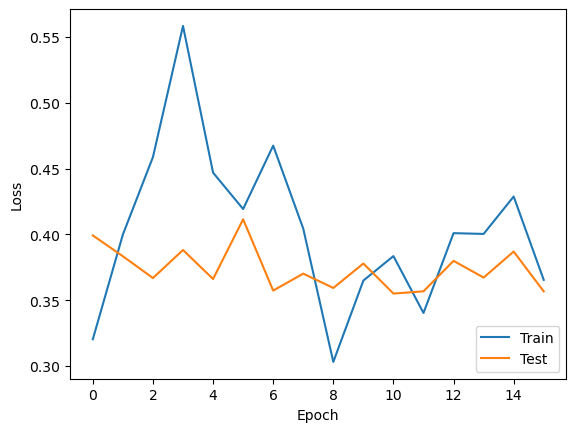

In [21]:
#make some quick plots
figure = plt.figure()
plt.xlabel("Epoch")
plt.ylabel('Loss')
plt.plot(loss_train)
plt.plot(loss_test)
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig(f"loss.pdf")